## Identificación de tópicos
## Elaborado por TreeData
## Versión Mayo 5 de 2022

In [82]:
# Instalación de módulos necesarios
%load_ext autoreload
%autoreload 2
from read_files import *
import numpy as np
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt 
import gensim
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
import tqdm
warnings.filterwarnings("ignore",category=DeprecationWarning)
#Modulo para realizar la nuebe de palabras
from wordcloud import WordCloud

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Lectura de datos

A continuación tendremos las siguientes funciones claves:

**get_pdf**: Esta función lee los archivos en formato pdf, quita simbolos de páginas web y otros simbolos.

**get_txt**: Esta función lee los archivos en formato txt.

**text_to_eng**: Esta función traduce los documentos del idioma español al inglés. Si desea realizar cambios en el idioma cambie en la función source='es'y target='en' (source es el idioma del documento y target es el idioma al cual se va a traducir) por los correspondientes idiomas. 

**clean_tokenize**: Esta función toma cada documento y le realiza los siguientes procesamientos:

-Convertir en minusculas el texto  
-Eliminar paginas web, signos de puntuación y espacios en blanco  
-Tokenizar el texto  
-Eliminar Stop Words (Si identifica nuevas Stop Words las debe agregar en el archivo 'stop_words.csv') 
-Lematizacion  

Estos resultados estan sujetos al rendimiento de la libreria NLTK, la cual es de las mas potentes para procesamiento de lenguaje natural.

In [19]:
# Poner en carpeta "files" todos los documentos que quiere segmentar en el idioma correspondiente, admite pdf y txt
data = get_data("data/files/")

ingles
procesando Investigacion 33.txt
procesado el texto!
procesando Investigacion 27.txt
procesado el texto!
procesando Investigacion 26.txt
procesado el texto!
procesando Investigacion 32.txt
procesado el texto!
procesando investigacion 18.txt
procesado el texto!
procesando investigacion 24.txt
procesado el texto!
procesando Investigacion 30.txt
procesado el texto!
procesando Investigacion 31.txt
procesado el texto!
procesando Investigacion 25.txt
procesado el texto!
procesando investigacion 19.txt
procesado el texto!
procesando Investigacion 21.txt
procesado el texto!
procesando Investigacion 35.txt
procesado el texto!
procesando Investigacion 34.txt
procesado el texto!
procesando investigacion 20.txt
procesado el texto!
procesando Investigacion 36.txt
procesado el texto!
procesando Investigacion 22.txt
procesado el texto!
procesando Investigacion 23.txt
procesado el texto!
procesando Investigacion 37.txt
procesado el texto!
procesando Investigacion 50.txt
procesado el texto!
proce

In [20]:
print(data.shape)
data.head()

(71, 4)


,document,idioma,file,clean_text
0,Scientific Fields of Interest: Environment; PG...,ingles,Investigacion 33.txt,"[scientific, field, interest, environment, pgr..."
1,Agriculture; Biology; Environment; Marine.\nMa...,ingles,Investigacion 27.txt,"[agriculture, biology, environment, marine, li..."
2,": Centrifuges, spectrophotometers, chromatogra...",ingles,Investigacion 26.txt,"[centrifuge, spectrophotometer, chromatography..."
3,Scientific Fields of Interest: Agriculture; Bi...,ingles,Investigacion 32.txt,"[scientific, field, interest, agriculture, bio..."
4,Several adoption models have been developed to...,ingles,investigacion 18.txt,"[several, adoption, model, developed, explain,..."


**document:** Contiene todo el texto original del documento.  
**idioma:** Identifica el dioma del documento original.  
**file:** Contiene el nombre del archivo que contiene el texto.  
**clean_text:** Contiene el texto limpio y tokenizado, resultante de aplicar la función clean_tokenize.

## Visualización de datos (Nube de palabras) por documento  
En esta sección queremos visualizar las palabras presentes en nuestro documento. Para cambiar de documento seleccione un número desde cero hasta 68 en df['document'][Número de documento].

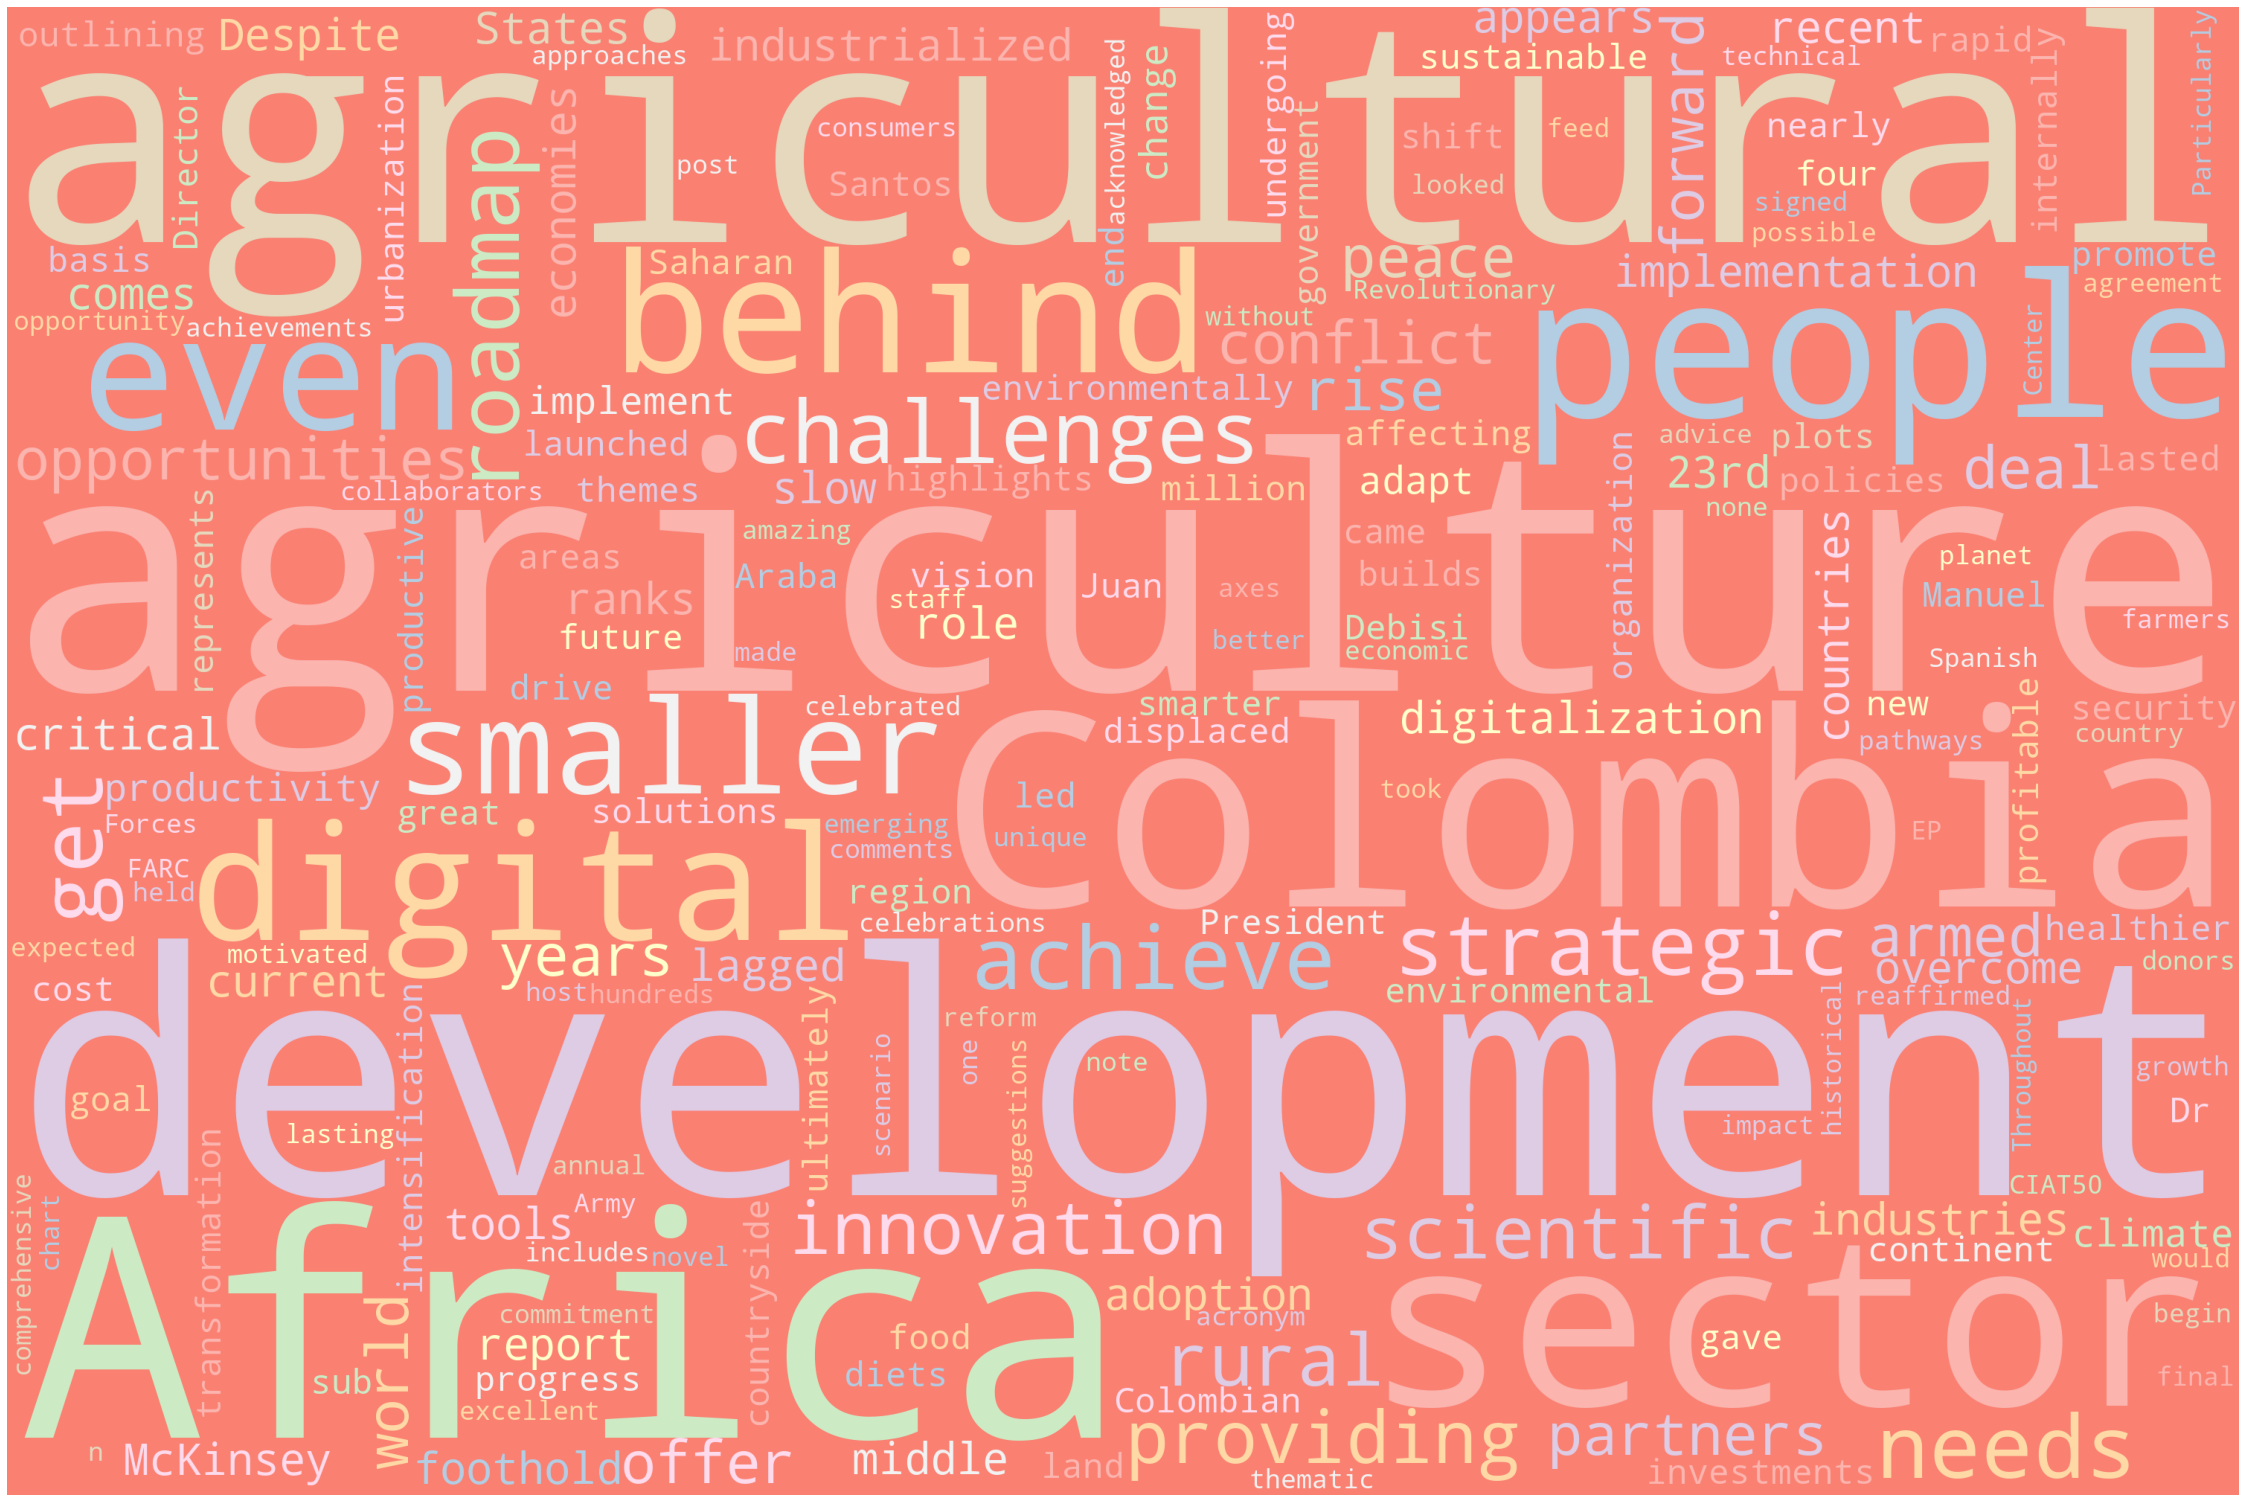

In [21]:
# Join the different processed titles together.
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
new_stop = pd.read_csv('stop_words.csv')
# lista de stop words en español
stop_words = stopwords.words('english')
stop_words.extend(new_stop['palabra'])
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
            background_color='salmon', colormap='Pastel1', 
            collocations=False, stopwords = stop_words).generate(data['document'][60]) ## Seleccione aqui documento del 0-68
plot_cloud(wordcloud)

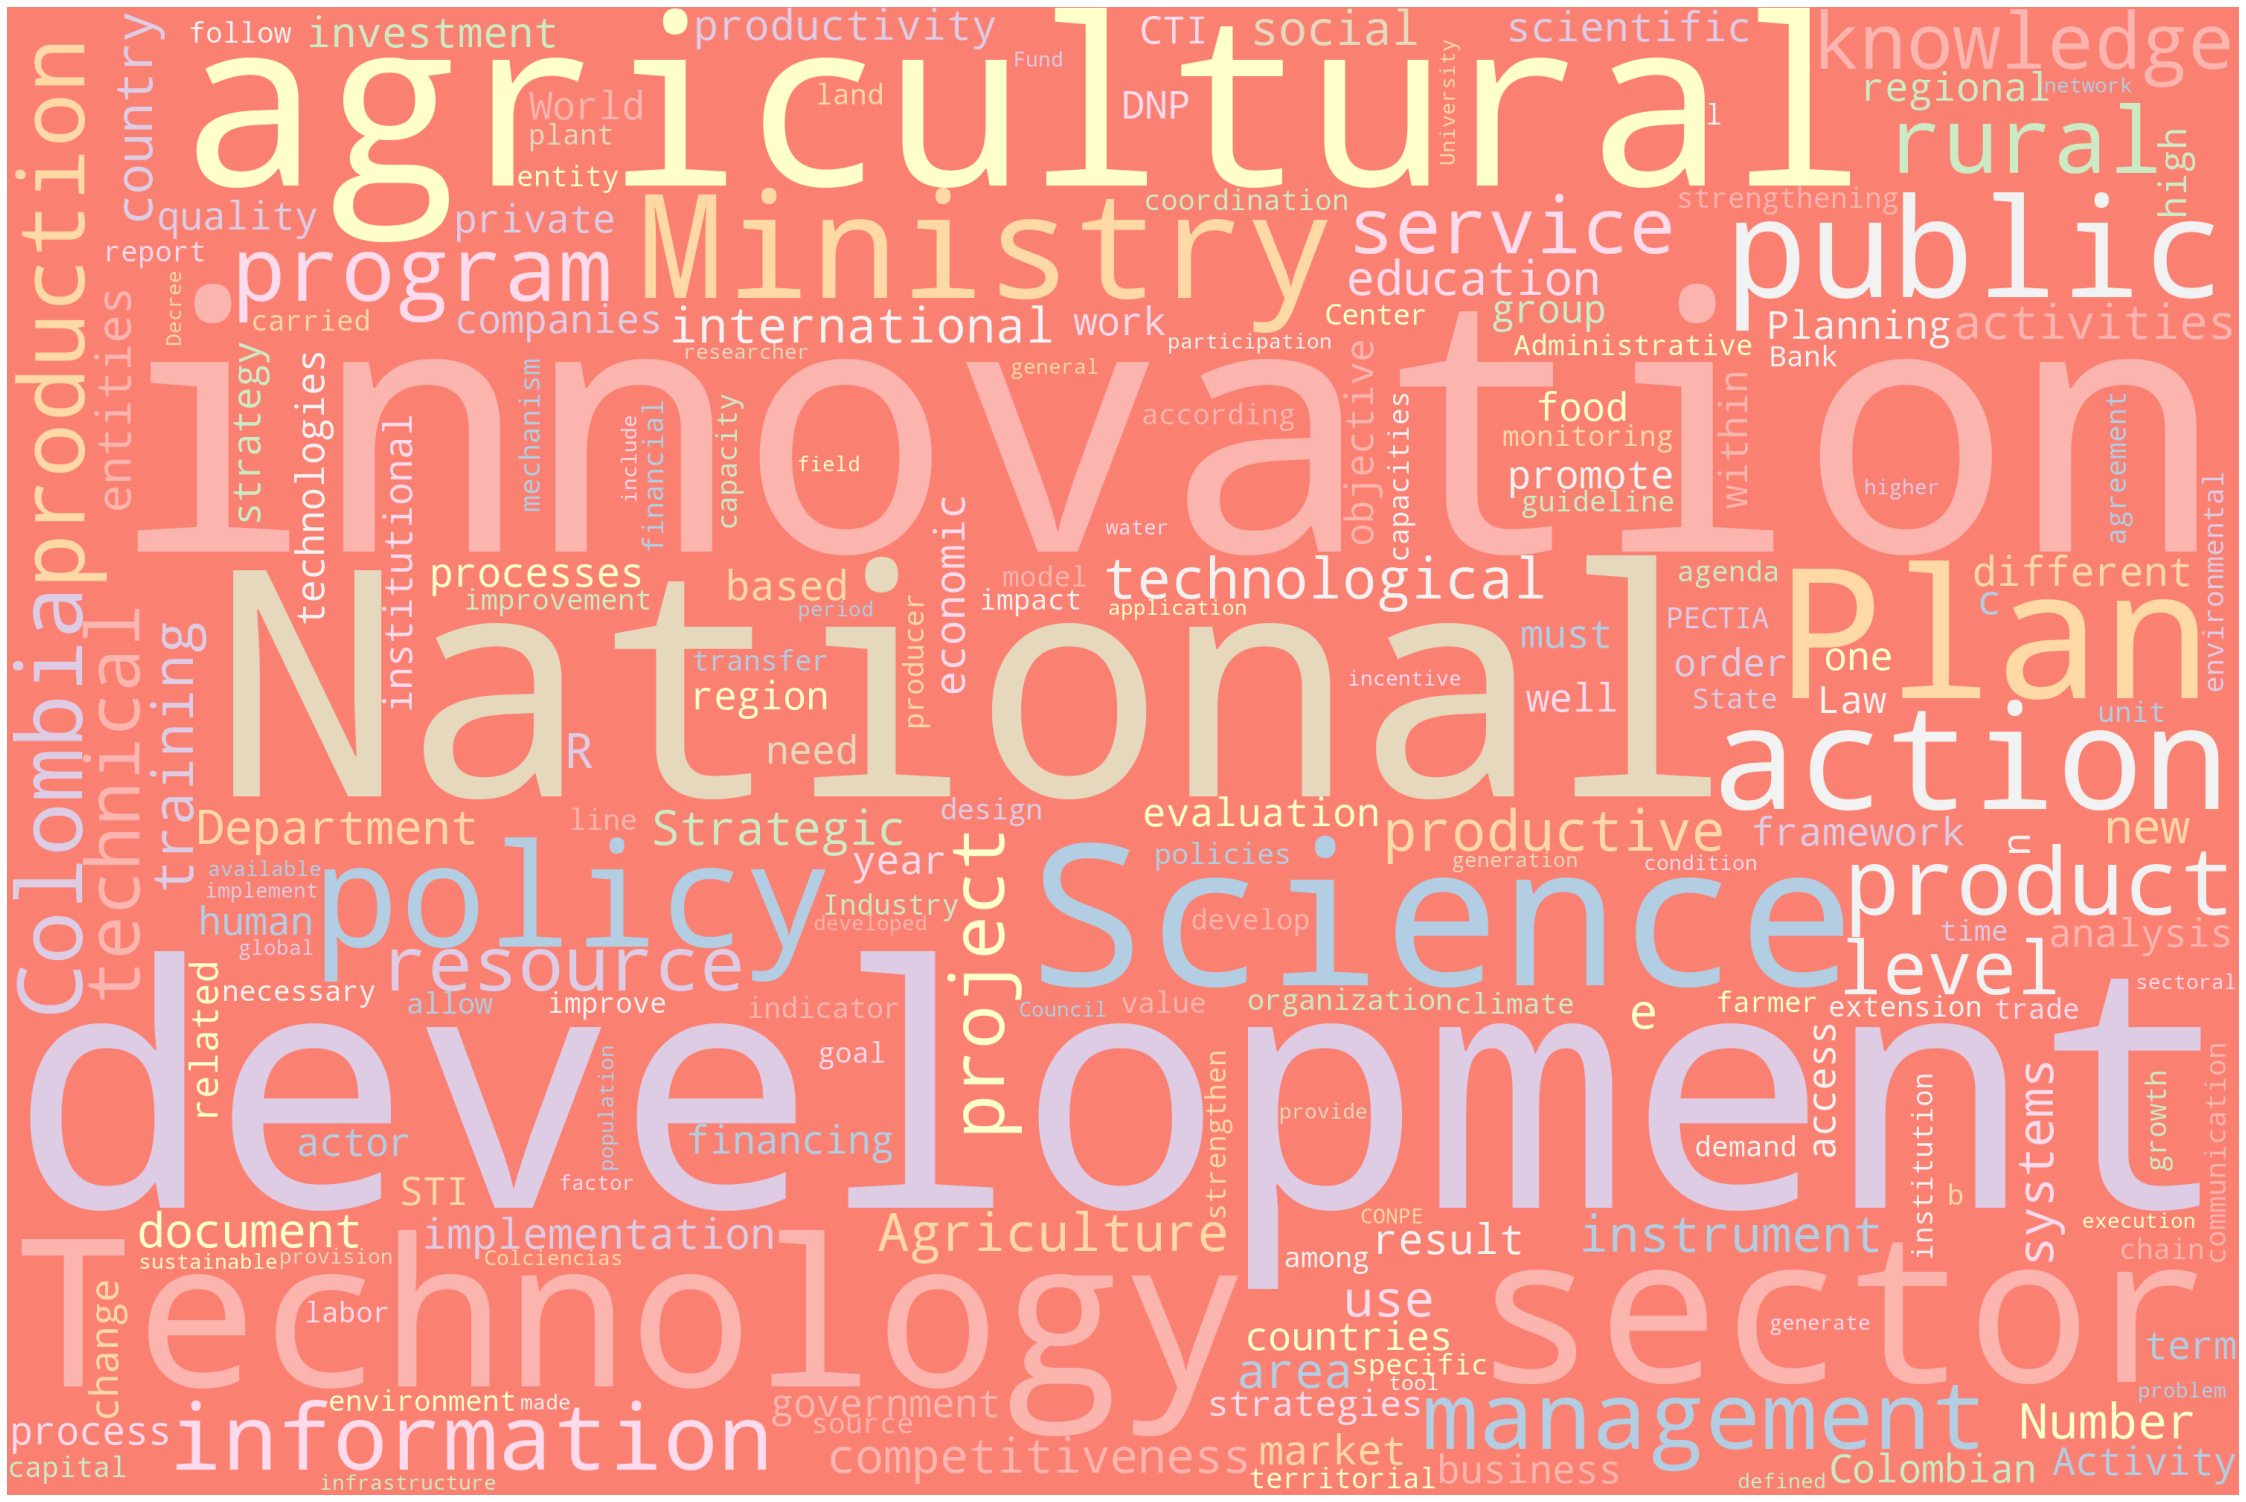

In [23]:
## Wordcloud global
textos = ",".join(list(data['document'].values))
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                background_color='salmon', colormap='Pastel1', 
                collocations=False, stopwords = stop_words).generate(textos) ## Seleccione aqui documento del 0-60
plot_cloud(wordcloud)

## Iniciando con el modelo LDA
Creamos y reducimos el diccionario filtrando las palabras más raras o demasiado frecuentes. Para ello haremos uso de la función filter_extremes, que nos proporciona el objeto Dictionary y que nos servirá para mantener únicamente aquellos tokens que se encuentran en al menos 2 documentos (no_below) y los que están contenidos en no más del 80% de documentos (no_above).

In [24]:
#Creando el diccionario
dictionary = gensim.corpora.Dictionary(data['clean_text'])
print('Antes de filtrar')
print(dictionary)
dictionary.filter_extremes(no_below=5,no_above=0.8)
print('Despues de filtrar')
print(dictionary)

Antes de filtrar
Dictionary(11069 unique tokens: ['acre', 'activity', 'agri', 'available', 'back']...)
Despues de filtrar
Dictionary(2459 unique tokens: ['agri', 'available', 'back', 'bank', 'biodiversity']...)


Inicializamos el corpus en base al diccionario que acabamos de crear. Cada documento se transformará en una bolsa de palabras (BOW del inglés bag-of-words) con las frecuencias de aparición.

Tras aplicar esta técnica veremos que cada documento está representado como una lista de tuplas donde el primer elemento es el identificador numérico de la palabra y el segundo es el número de veces que esa palabra aparece en el documento.

In [25]:
#Creación del corpus
corpus = [dictionary.doc2bow(text) for text in data['clean_text']]
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('agri', 1),
  ('available', 1),
  ('back', 1),
  ('bank', 1),
  ('biodiversity', 1),
  ('centre', 1),
  ('characterization', 1),
  ('collection', 1),
  ('computer', 1),
  ('conservation', 5),
  ('crop', 1),
  ('culture', 4),
  ('database', 1),
  ('degree', 2),
  ('developed', 1),
  ('dna', 2),
  ('electron', 1),
  ('environment', 1),
  ('evaluation', 2),
  ('ex', 3),
  ('excellence', 1),
  ('exchange', 2),
  ('exploration', 1),
  ('facility', 3),
  ('farm', 3),
  ('future', 1),
  ('gene', 1),
  ('genetic', 1),
  ('germplasm', 6),
  ('integration', 1),
  ('interest', 1),
  ('introduction', 1),
  ('job', 1),
  ('laboratory', 1),
  ('line', 1),
  ('long', 1),
  ('microscope', 1),
  ('module', 1),
  ('molecular', 2),
  ('phd', 1),
  ('plan', 1),
  ('plant', 6),
  ('postgraduate', 1),
  ('programme', 2),
  ('protocol', 2),
  ('reader', 1),
  ('regional', 1),
  ('relative', 1),
  ('resource', 1),
  ('sample', 1),
  ('seed', 2),
  ('several', 2),
  ('specie', 1),
  ('station', 1),
  ('term

## Encontrando el numero óptimo de valores de los parámetros (k, alpha y beta)

La siguiente función es usada para encontrar el número óptimo de parámetros para el modelo,para cada modelo de calcula la perplejidad y coherencia. 

In [63]:
#Función para encontrar los parametros optimos del modelo k, alpha, beta
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data['clean_text'], dictionary=dictionary, coherence='c_v')
    per=lda_model.log_perplexity(corpus)
    return coherence_model_lda.get_coherence(),per

Si desea ampliar la busqueda cambien en las siguientes opciones el valor deseado:  

# Topics range 
min_topics = 2
max_topics = 4
step_size = 1

# Alpha parameter (minimo esta en 0.1 y máximo en 0.5,con salto de 0.1)
alpha = list(np.arange(0.1,0.5, 0.1))

# Beta parameter  (minimo esta en 0.1 y máximo en 0.5, con salto de 0.1)
beta = list(np.arange(0.2, 0.5, 0.1))

In [64]:
grid = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.1,0.5, 0.1))

# Beta parameter
beta = list(np.arange(0.2, 0.5, 0.1))
#beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplejidad': []
                }
# iterate through number of topics
for k in topics_range:
    print(k)
# iterate through alpha values
    for a in alpha:
        print(a)
 # iterare through beta values
        for b in beta:
            print(b)
            cv = compute_coherence_values(corpus=corpus, dictionary=dictionary,k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv[0])
            model_results['Perplejidad'].append(cv[1]) 

2
0.1
0.2
0.30000000000000004
0.4000000000000001
0.2
0.2
0.30000000000000004
0.4000000000000001
0.30000000000000004
0.2
0.30000000000000004
0.4000000000000001
0.4
0.2
0.30000000000000004
0.4000000000000001
3
0.1
0.2
0.30000000000000004
0.4000000000000001
0.2
0.2
0.30000000000000004
0.4000000000000001
0.30000000000000004
0.2
0.30000000000000004
0.4000000000000001
0.4
0.2
0.30000000000000004
0.4000000000000001
4
0.1
0.2
0.30000000000000004
0.4000000000000001
0.2
0.2
0.30000000000000004
0.4000000000000001
0.30000000000000004
0.2
0.30000000000000004
0.4000000000000001
0.4
0.2
0.30000000000000004
0.4000000000000001
5
0.1
0.2
0.30000000000000004
0.4000000000000001
0.2
0.2
0.30000000000000004
0.4000000000000001
0.30000000000000004
0.2
0.30000000000000004
0.4000000000000001
0.4
0.2
0.30000000000000004
0.4000000000000001
6
0.1
0.2
0.30000000000000004
0.4000000000000001
0.2
0.2
0.30000000000000004
0.4000000000000001
0.30000000000000004
0.2
0.30000000000000004
0.4000000000000001
0.4
0.2
0.3000000

In [69]:
#Obteniendo el mejor modelo acorde con la coherencia          
Resultados=pd.DataFrame(model_results)
Resultados[Resultados['Coherence'] == Resultados['Coherence'].max()]

,Topics,Alpha,Beta,Coherence,Perplejidad
36,5,0.1,0.2,0.445925,-6.830795


In [70]:
#Obteniendo el mejor modelo acorde con la Perplejidad   
Resultados=pd.DataFrame(model_results)
Resultados[Resultados['Perplejidad'] == Resultados['Perplejidad'].min()]

,Topics,Alpha,Beta,Coherence,Perplejidad
9,2,0.4,0.2,0.363448,-6.918628


In [72]:
Resultados1=pd.DataFrame(model_results)
Resultados1

,Topics,Alpha,Beta,Coherence,Perplejidad
0,2,0.1,0.2,0.363448,-6.916284
1,2,0.1,0.3,0.363448,-6.911219
2,2,0.1,0.4,0.355930,-6.910016
3,2,0.2,0.2,0.363448,-6.917054
4,2,0.2,0.3,0.363448,-6.912571
...,...,...,...,...,...
91,9,0.3,0.3,0.415782,-6.824433
92,9,0.3,0.4,0.414150,-6.820995
93,9,0.4,0.2,0.394773,-6.837316
94,9,0.4,0.3,0.410772,-6.826189


## Gráfico de coherencia para valores especificos de alpha y beta

In [73]:
alpha1=0.1
beta1=0.2
Resultados2=Resultados1[(Resultados1["Alpha"]==alpha1) & (Resultados1["Beta"]==beta1)]
Resultados2

,Topics,Alpha,Beta,Coherence,Perplejidad
0,2,0.1,0.2,0.363448,-6.916284
12,3,0.1,0.2,0.407235,-6.865494
24,4,0.1,0.2,0.426407,-6.844352
36,5,0.1,0.2,0.445925,-6.830795
48,6,0.1,0.2,0.399983,-6.840780
60,7,0.1,0.2,0.435797,-6.818069
72,8,0.1,0.2,0.406343,-6.833048
84,9,0.1,0.2,0.419609,-6.832496


### Coherencia

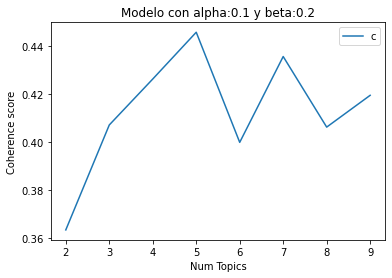

In [97]:
coherence_values=Resultados2["Coherence"]
x = Resultados2["Topics"]
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("Modelo con alpha:" + str(alpha1) +" y beta:"+ str(beta1))
plt.show()

### Perplejidad

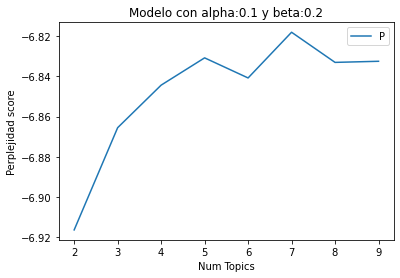

In [98]:
Perplejidad_values=Resultados2["Perplejidad"]
x = Resultados2["Topics"]
plt.plot(x, Perplejidad_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplejidad score")
plt.legend(("Perplejidad_values"), loc='best')
plt.title("Modelo con alpha:" + str(alpha1) +" y beta:"+ str(beta1))
plt.show()

Seleccionamos la combinacion de parametros que optimiza la coherencia

In [78]:
#Modelo LDA con los parámetros seleccionados
k = 5
a = 0.1
b = 0.2
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

chunksize controla cuántos documentos se procesan a la vez en el algoritmo de entrenamiento. Aumentar el tamaño de los fragmentos acelerará el entrenamiento, al menos mientras el fragmento de documentos quepa fácilmente en la memoria. pass controla la frecuencia con la que entrenamos el modelo en todo el corpus (establecido en 10). Otra palabra para pases podría ser "épocas". iteraciones es algo técnico, pero esencialmente controla la frecuencia con la que repetimos un ciclo particular sobre cada documento. Es importante establecer el número de "pasos" e "iteraciones" lo suficientemente alto.

In [79]:
# Compute Perplexity del modelo seleccionado
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.830794894230035


In [80]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['clean_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4459245806652314


In [83]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus,dictionary)
vis

/Users/user/anaconda3/envs/nlp/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.094419  0.018179       1        1  40.883674
0      0.117525 -0.030709       2        1  20.380536
1      0.041830  0.000006       3        1  20.215441
4     -0.108241  0.099614       4        1  16.030305
3     -0.145534 -0.087091       5        1   2.490044, topic_info=             Term         Freq        Total Category  logprob  loglift
139       science  1041.000000  1041.000000  Default  30.0000  30.0000
162  agricultural  1378.000000  1378.000000  Default  29.0000  29.0000
56       training   576.000000   576.000000  Default  28.0000  28.0000
40           plan   877.000000   877.000000  Default  27.0000  27.0000
648        number   487.000000   487.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
313          soil    21.762811   166.703887   Topic5  -5.1134   1.6569
17    environment    21.839210   220.841325   Topic5  -5.1099   1.3791
159         water    20.277100   169.886140   Topic5  -5.1842   1.5672
243   improvement    20.673837   241.115554   Topic5  -5.1648   1.2365
48       resource    21.956367   628.860080   Topic5  -5.1046   0.3380

[389 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2199      1  0.277046   accordance
2199      2  0.633247   accordance
2199      3  0.087072   accordance
2199      4  0.007916   accordance
2128      1  0.150695  accumulated
...     ...       ...          ...
1067      1  0.081850        yield
1067      2  0.020462        yield
1067      3  0.081850        yield
1067      4  0.808268        yield
1067      5  0.010231        yield

[1131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

El control deslizante λ permite clasificar los términos según su relevancia. De forma predeterminada, los términos de un tema se clasifican en orden decreciente según su probabilidad específica del tema ( λ = 1 ). Mover el control deslizante permite ajustar la clasificación de los términos según su grado de discriminación (o "relevancia") para el tema específico. El valor "óptimo" sugerido de λ es 0,6.

El mapa de distancia entre temas es una visualización de los temas en un espacio bidimensional.

El área de estos círculos de temas es proporcional a la cantidad de palabras que pertenecen a cada tema en el diccionario.

El gráfico de barras muestra por defecto los 30 términos más destacados. Las barras indican la frecuencia total del término en todo el corpus.

Salient es una métrica específica, definida en la parte inferior de la visualización, que se puede considerar como una métrica utilizada para identificar las palabras más informativas o útiles para identificar temas en toda la colección de textos.

## La línea a continuación nos muestra la composicióin de cada tópico y para cada uno muestra las 10 principales palabras

In [84]:
topicos = lda_model.print_topics(num_words=10, num_topics=k)
for topico in topicos:
    print(topico)

(0, '0.017*"rural" + 0.016*"agricultural" + 0.014*"plan" + 0.010*"management" + 0.009*"service" + 0.009*"ministry" + 0.009*"entity" + 0.009*"policy" + 0.009*"action" + 0.008*"information"')
(1, '0.023*"agricultural" + 0.022*"innovation" + 0.015*"sector" + 0.014*"national" + 0.012*"science" + 0.009*"production" + 0.008*"strategic" + 0.008*"plan" + 0.007*"colombia" + 0.007*"system"')
(2, '0.017*"innovation" + 0.014*"national" + 0.011*"policy" + 0.010*"science" + 0.009*"ministry" + 0.009*"country" + 0.008*"sector" + 0.008*"action" + 0.007*"public" + 0.007*"program"')
(3, '0.017*"training" + 0.013*"science" + 0.013*"plant" + 0.012*"number" + 0.012*"facility" + 0.011*"production" + 0.010*"agricultural" + 0.010*"line" + 0.009*"management" + 0.009*"laboratory"')
(4, '0.008*"farmer" + 0.007*"food" + 0.006*"international" + 0.006*"plant" + 0.006*"climate" + 0.006*"system" + 0.005*"agricultural" + 0.005*"country" + 0.005*"change" + 0.005*"project"')


## Nube de palabras para cada tópico

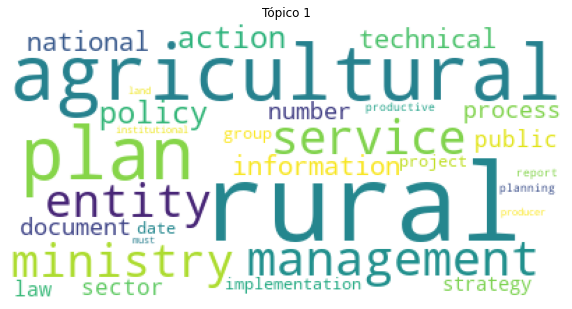

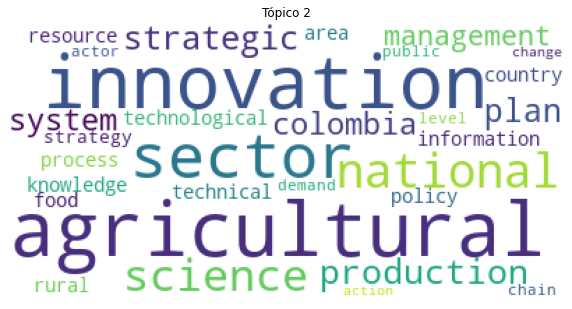

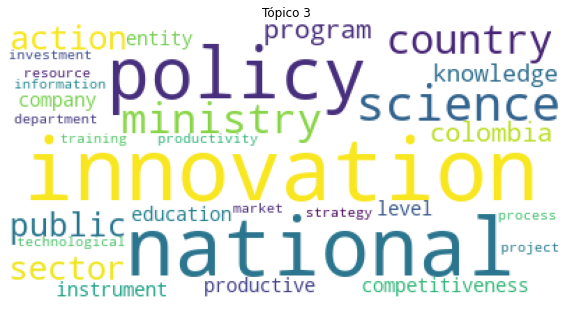

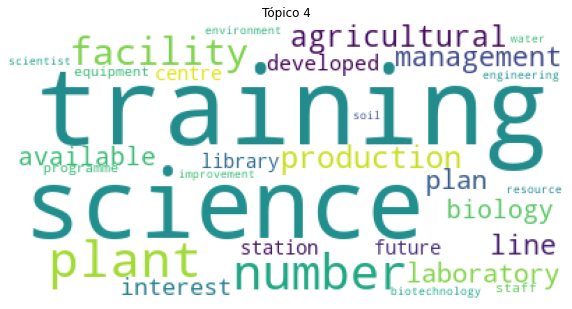

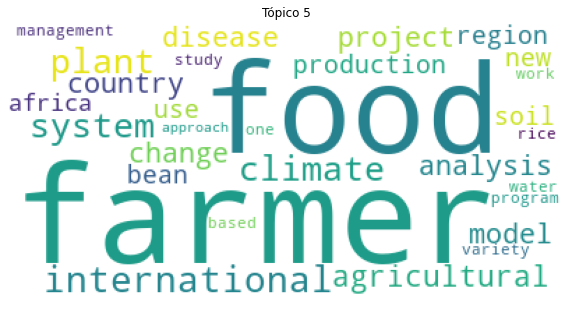

In [85]:
for i in range(0, k):
    plt.figure(figsize=(10,10))
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda_model.show_topic(i, 30))))
    plt.axis("off")
    plt.title("Tópico " + str(i+1))
    plt.show()

## Distribución de los tópicos en el documento

In [86]:
#Especifique en d el número de documento para el cual desea hacer la distribución de los tópicos
d=20
bow_noticia = corpus[d]
# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda_model[bow_noticia]]
# Contribución de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda_model[bow_noticia]]

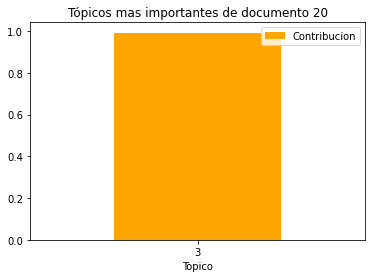

In [87]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="orange",
                                   title = 'Tópicos mas importantes'
                                   ' de documento ' + str(d))

## Tópico más representativo por documento

In [88]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [99]:
df_topic_sents_keywords=format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data["file"])
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(15)

/var/folders/3q/9955_sms3mx53zh_j_08k6b00000gn/T/ipykernel_1337/4124948175.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/3q/9955_sms3mx53zh_j_08k6b00000gn/T/ipykernel_1337/4124948175.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.9959,"training, science, plant, number, facility, pr...",Investigacion 33.txt
1,1,3,0.7352,"training, science, plant, number, facility, pr...",Investigacion 27.txt
2,2,3,0.6201,"training, science, plant, number, facility, pr...",Investigacion 26.txt
3,3,3,0.8699,"training, science, plant, number, facility, pr...",Investigacion 32.txt
4,4,4,0.8866,"farmer, food, international, plant, climate, s...",investigacion 18.txt
5,5,4,0.9996,"farmer, food, international, plant, climate, s...",investigacion 24.txt
6,6,3,0.7700,"training, science, plant, number, facility, pr...",Investigacion 30.txt
7,7,3,0.5752,"training, science, plant, number, facility, pr...",Investigacion 31.txt
8,8,4,0.8007,"farmer, food, international, plant, climate, s...",Investigacion 25.txt
9,9,4,0.7660,"farmer, food, international, plant, climate, s...",investigacion 19.txt


## El documento más representativo de cada tópico

In [91]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

In [92]:
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [93]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [94]:
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9995,"rural, agricultural, plan, management, service...",PLAN_DE_ACCION_INSTITUCIONAL_VIGENCIA_2021.pdf
1,1,0.9708,"agricultural, innovation, sector, national, sc...",pectia-2017-actualizado.pdf
2,2,0.9998,"innovation, national, policy, science, ministr...",CPC_INC_2020_2021_Ciencia-tecnologia.pdf
3,3,0.9978,"training, science, plant, number, facility, pr...",Investigacion 49.txt
4,4,0.9998,"farmer, food, international, plant, climate, s...",Investigacion 5.txt


## Distribución de los tópicos en los documentos

In [95]:
# Número de documentos para cada tópico
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

In [96]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

3    0.4930
4    0.3662
2    0.0845
0    0.0282
1    0.0282
Name: Dominant_Topic, dtype: float64